# Notebook 2 of 2

## This noteboook continues the work started in Notebook 1.        
> ### Here we will iterate through several neural network models to find the best accurracy in predicting whether a B-cell is normal or malignant with Acute Lymphoblastic Leukemia


In [22]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import pandas as pd
import numpy as np
import csv
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import optimizers
from keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.metrics import binary_crossentropy, categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
import time
import scipy
from scipy import ndimage
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
import splitfolders
logging.getLogger("tensorflow").setLevel(logging.ERROR)
np.random.seed(123)
print ('modules loaded')

modules loaded


### First we must generate the data in this notebook.

In [2]:
# Create data generators
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/train',
        class_mode='binary',
        target_size=(65,65),
        batch_size=10024)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/validation',
        class_mode='binary',
        target_size=(65,65),
        batch_size = 2379)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/tvt/test',
        class_mode='binary',
        target_size=(65,65),
        batch_size = 125)

Found 10024 images belonging to 2 classes.
Found 2379 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [3]:
# create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [15]:
train_labels[:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [4]:
#  Un-row the image matrices for modeling
train_x = train_images.reshape(train_images.shape[0], -1)
test_x = test_images.reshape(test_images.shape[0], -1)
val_x = val_images.reshape(val_images.shape[0], -1)

In [5]:
# The datasets is imbalanced so we will define class_weight = balanced
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_generator.classes),
                                                  y=train_generator.classes
                                                 )

train_class_weights = dict(enumerate(class_weights))

## Build a basic Convolutional Neural Network

In [6]:
# Instantiate the model and build it's layers
cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(16,(3,3), activation='relu', input_shape=(65,65,3)))
cnn1.add(layers.MaxPool2D(2,2))
cnn1.add(layers.Conv2D(32,(3,3), activation='relu'))
cnn1.add(layers.MaxPool2D(2,2))
cnn1.add(layers.Conv2D(64,(3,3), activation='relu'))
cnn1.add(layers.MaxPool2D(2,2))
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(512, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

In [11]:
# Compile the model
cnn1.compile(optimizer=RMSprop(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit and Train the model
cnn1_history = cnn1.fit(train_generator,
                        epochs=50,
                        batch_size=5000,
                        validation_data=(val_generator),
                        class_weight=train_class_weights,)

Epoch 1/50
1/1 [==============================] - 17s 17s/step - loss: 0.7786 - accuracy: 0.3678 - val_loss: 0.6618 - val_accuracy: 0.7297
Epoch 2/50
1/1 [==============================] - 15s 15s/step - loss: 0.6749 - accuracy: 0.7238 - val_loss: 0.6386 - val_accuracy: 0.7251
Epoch 3/50
1/1 [==============================] - 15s 15s/step - loss: 0.6582 - accuracy: 0.7254 - val_loss: 0.6224 - val_accuracy: 0.6999
Epoch 4/50
1/1 [==============================] - 16s 16s/step - loss: 0.6339 - accuracy: 0.7083 - val_loss: 0.5792 - val_accuracy: 0.7104
Epoch 5/50
1/1 [==============================] - 15s 15s/step - loss: 0.6149 - accuracy: 0.7209 - val_loss: 0.9041 - val_accuracy: 0.3682
Epoch 6/50
1/1 [==============================] - 16s 16s/step - loss: 0.7709 - accuracy: 0.3678 - val_loss: 0.5784 - val_accuracy: 0.7247
Epoch 7/50
1/1 [==============================] - 15s 15s/step - loss: 0.6364 - accuracy: 0.7277 - val_loss: 0.6166 - val_accuracy: 0.6873
Epoch 8/50
1/1 [===========

In [29]:
# Create visualization functions

def visualize_training_results(results):
    history = results.history
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,5))
    ax1.plot(history['loss'], label='Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.grid(False)
    ax1.legend()

    ax2.plot(history['accuracy'], label = 'Accuracy')
    ax2.plot(history['val_accuracy'], label='Val Accuracy')
    ax2.grid(False)
    ax2.legend();

def plot_confusion_matrix(model, y_true, y_images):
    predictions = model.predict(y_images)
    y_pred = np.round(predictions, 0)
    y_pred = np.reshape(y_pred, -1)

    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ALL','Normal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()   

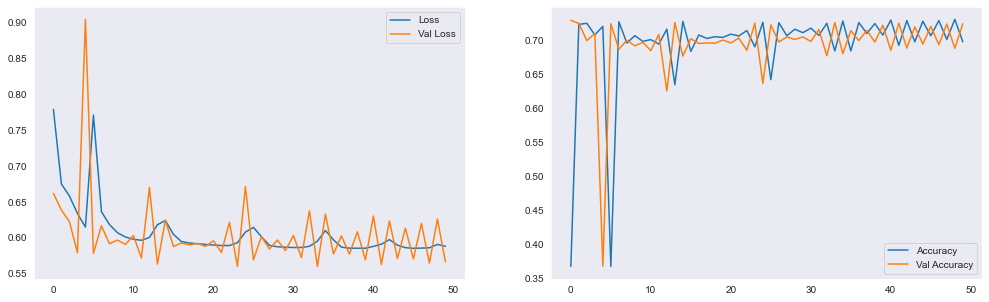

In [30]:
# Visualize CNN1 results
visualize_training_results(cnn1_history)

In [33]:
test_results = cnn1.evaluate(test_generator)

1/1 [==============================] - 0s 114ms/step - loss: 0.5115 - accuracy: 0.7920


              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85        79
         1.0       0.78      0.61      0.68        46

    accuracy                           0.79       125
   macro avg       0.79      0.75      0.76       125
weighted avg       0.79      0.79      0.79       125



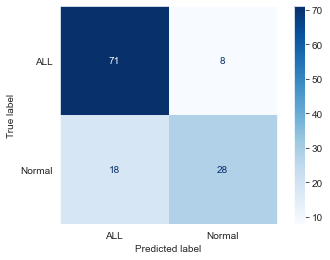

In [32]:
plot_confusion_matrix(cnn1, test_labels, test_images)